In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

In [4]:
df = pd.read_csv('./classification_challenge_submission.csv') # read in the census-derived data; mind the separator
df.head()

,Unnamed: 0,age,type_employer,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hr_per_week,country
0,18099,45,Federal-gov,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,20,United-States
1,10672,17,Private,12th,8,Never-married,Sales,Own-child,White,Male,0,0,40,United-States
2,17947,24,Private,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,United-States
3,13753,46,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Black,Male,4064,0,40,United-States
4,4279,59,Private,Bachelors,13,Separated,Adm-clerical,Unmarried,White,Male,0,0,60,United-States


In [5]:
# Check values and their counts
pd.set_option('display.max_rows', 500)
df.apply(lambda c: c.value_counts()).T.stack()
df[['education', 'education_num']].drop_duplicates()

df_clean = df[df['type_employer'] != '?']
df_clean_all1 = df_clean[df_clean['country'] != '?']
df_clean_all = df_clean_all1[df_clean_all1['occupation'] != '?']
df_clean_all.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7567 entries, 0 to 8140
Data columns (total 14 columns):
Unnamed: 0       7567 non-null int64
age              7567 non-null int64
type_employer    7567 non-null object
education        7567 non-null object
education_num    7567 non-null int64
marital          7567 non-null object
occupation       7567 non-null object
relationship     7567 non-null object
race             7567 non-null object
sex              7567 non-null object
capital_gain     7567 non-null int64
capital_loss     7567 non-null int64
hr_per_week      7567 non-null int64
country          7567 non-null object
dtypes: int64(6), object(8)
memory usage: 886.8+ KB


In [7]:
"""Clean/munge your data."""


col_list = df_clean_all.columns
cols_to_drop = ['Unnamed: 0', 'education_num', 'relationship']
df2 = df_clean_all.copy()
df2.drop(cols_to_drop, axis=1, inplace=True)


#X_train, X_test, Y_train, Y_test = train_test_split(df, target) ## create train-test out of the data given
#col_list
df2.shape

(7567, 11)

In [ ]:
#X = df2
#y = df_clean_all['income']
#X_train, X_test, Y_train, Y_test = train_test_split(df2, y)

In [93]:
df_clean_all['country'].value_counts()

United-States                 20574
Mexico                          472
Philippines                     133
Germany                          96
Canada                           81
Puerto-Rico                      79
India                            78
El-Salvador                      72
Cuba                             70
Jamaica                          60
England                          59
China                            58
South                            57
Italy                            55
Vietnam                          50
Dominican-Republic               50
Japan                            47
Columbia                         46
Guatemala                        46
Poland                           42
Iran                             34
Haiti                            29
Portugal                         28
Taiwan                           28
Peru                             27
Ecuador                          24
Greece                           23
Nicaragua                   

In [123]:
""" Fit a binary classification predictor."""
from sklearn.linear_model import LogisticRegression
import patsy

X = patsy.dmatrix('~ age + C(type_employer) + C(education) + C(marital) + C(occupation)\
                    + C(race) + C(sex) + capital_gain + capital_loss + hr_per_week + C(country)', df2)
y = df_clean_all['income'].values

#X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = .66)
model = LogisticRegression() 

#model.fit(X, y) # This fits the model to learn the coefficients
model.fit(X_train, Y_train) # This fits the model to learn the coefficients
#examine_coefficients(model, X)

y_pred = model.predict(X_test)
y_score = model.decision_function(X_test) # Submit these response, the output of model.decision_function

In [107]:
from sklearn.grid_search import GridSearchCV

logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=15)
gs.fit(X, y)


/Applications/anaconda/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=15, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.25, 0.275, 0.33, 0.5, 0.66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [108]:
gs.best_params_

{'C': 1.0, 'penalty': 'l1'}

In [116]:
logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
cv_model = logreg.fit(X_train, Y_train)
cv_predict = cv_model.predict(X_test)

In [121]:
print classification_report(Y_test, cv_predict, labels=cv_model.classes_)

             precision    recall  f1-score   support

          0       0.88      0.93      0.90      5766
          1       0.75      0.61      0.67      1917

avg / total       0.85      0.85      0.85      7683



In [124]:
print classification_report(Y_test, y_pred, labels=model.classes_)

             precision    recall  f1-score   support

          0       0.88      0.93      0.90      5804
          1       0.73      0.62      0.67      1879

avg / total       0.84      0.85      0.85      7683



           predicted_over50k  predicted_under50k
over_50k                1163                 716
under_50k                433                5371
             precision    recall  f1-score   support

          0       0.88      0.93      0.90      5804
          1       0.73      0.62      0.67      1879

avg / total       0.84      0.85      0.85      7683



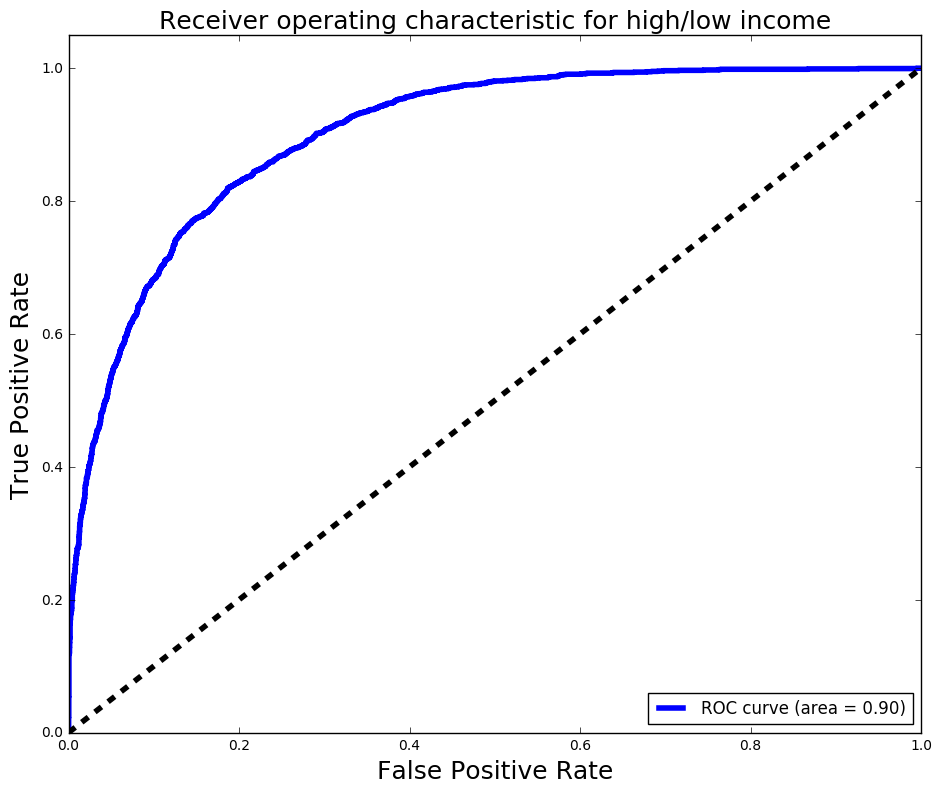

In [125]:
""" Check your performance so far."""

conmat = np.array(confusion_matrix(Y_test, y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over_50k', 'under_50k'],
                            columns=['predicted_over50k','predicted_under50k'])

print(confusion)
print classification_report(Y_test,y_pred)
roc_auc_score(Y_test, y_score)

""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high/low income', fontsize=18)
plt.legend(loc="lower right")
plt.show()